In [1]:
## Exercise 2
# 1 Comment on your solution to exercise 1b
# 2 Comment on others' solution to Exercise 1b


In [2]:
# 3 Data Preparation

import numpy as np
from sklearn.datasets import load_digits
from sklearn import model_selection


In [3]:
digits = load_digits()
print(digits.keys())
data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]
X_sub = data[ (target== 1)|(target== 7) , : ]
Y_sub = target[ (target== 1)|(target== 7) ]


dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


In [4]:
# Check the number of instances, and should be 361.

np.shape(X_sub)
np.shape(Y_sub)


(361,)

In [5]:
# 3.1 Dimension Reduction (4 points)
# f1: mean of pixel region around image[4:8,1:3] (row 5 to 8, column 2 to 4)
# f2: mean of pixel region aroung image[0:6,6]  (row 1 to 5, column 6)

def reduce_dim(x):
    xR = np.array([]).reshape(0,2)
    for i in range(len(x)):
        f1 = np.mean(x[i,:].reshape(8,8)[4:8,1:4])
        f2 = np.mean(x[i,:].reshape(8,8)[0:5,6])
        xR = np.append(xR, [[f1,f2]], axis=0)
    return xR


In [6]:
reduced_x = reduce_dim(X_sub)


In [7]:
np.shape(X_sub)


(361, 64)

In [8]:
np.shape(reduced_x)


(361, 2)

In [9]:
# Split the filtered dataset into train set and test set (#train/#test = 3/2)

X_train , X_test , Y_train , Y_test = model_selection.train_test_split(reduced_x, Y_sub,test_size = 0.4, random_state = 0)


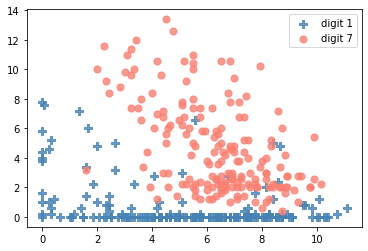

In [10]:
# 3.2 Scatterplot (4 points)

import matplotlib.pyplot as plt
plt.scatter(x=reduced_x[Y_sub == 1,0],y=reduced_x[Y_sub == 1,1], marker="P", color='steelblue',alpha=0.8,s=50,label="digit 1")
plt.scatter(x=reduced_x[Y_sub == 7,0],y=reduced_x[Y_sub == 7,1], marker="o", color='salmon',alpha=0.8,s=50,label="digit 7")
plt.legend()
plt.show()


In [11]:
# 4 Nearest Mean
# 4.1 Implement the nearest mean classifier (3 points)

def nearest_mean(training_features, training_labels, test_features):
    TL = [tl for tl in set(training_labels)]    # ==1,==7 
    TF = np.array([np.mean(training_features[training_labels==tl, : ], axis=0) for tl in TL])  # ==1,==7  ,  (2,2)
    distm =  np.linalg.norm(TF[ : , np.newaxis] - test_features, axis = 2)
    disti = np.argpartition(distm, kth = 1, axis = 0)[ :1 , : ]
    distv = np.array(TL)[disti]
    test_labels = np.array([ np.bincount(distv[ : , v ]).argmax() for v in range(len(distv[0])) ])
    return test_labels


In [12]:
predicted_labels = nearest_mean(training_features=X_train, training_labels=Y_train, test_features=X_test)


In [13]:
# 4.2 Visualize the decision regions (4 points)

def plotDecisionRegions(x, y, model):
    x1_min, x1_max = x[:, 0].min() - 0.5, x[:,0].max() + 0.5
    x2_min, x2_max = x[:, 1].min() - 0.5, x[:,1].max() + 0.5
    xx1, xx2= np.meshgrid (np.arange(x1_min, x1_max,step= (x1_max-x1_min)/200), np.arange(x2_min, x2_max,step=(x2_max-x2_min)/200))
    if model == nearest_mean:
        Z = model(training_features=x, training_labels=y, test_features=np.c_[xx1.ravel(), xx2.ravel()])
    elif model == predict_qda:
        mu, covmat, p = fit_qda(training_features=x, training_labels=y)
        Z = model(mu, covmat, p, test_features=np.c_[xx1.ravel(), xx2.ravel()])
    Z = Z.reshape(xx1.shape)
    TL = [tl for tl in set(y)]    # ==1,==7 
    TF = np.array([np.mean(x[y==tl, : ], axis=0) for tl in TL])
    plt.contour(xx1, xx2, Z, cmap=plt.cm.Paired, alpha= 0.3)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    mk = [m for m in range(4,12)]
    for i in range(len(TL)):
        rgb = np.random.rand(3,)
        plt.scatter(x=TF[TL == TL[i],0],y=TF[TL == TL[i],1], marker=mk[i], color=rgb,alpha=0.9,s=250,label=("Mean Y==" + str(TL[i])))
    pass


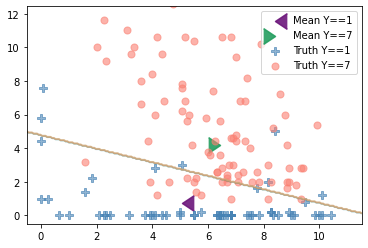

In [14]:
plotDecisionRegions(x=X_train,y=Y_train,model=nearest_mean)
plt.scatter(x=X_test[Y_test == 1,0],y=X_test[Y_test == 1,1], marker="P", color='steelblue',alpha=0.6,s=50,label="Truth Y==1")
plt.scatter(x=X_test[Y_test == 7,0],y=X_test[Y_test == 7,1], marker="o", color='salmon',alpha=0.6,s=50,label="Truth Y==7")
plt.legend()
plt.show()


In [15]:
# 5 QDA
# 5.1 Implement QDA Training (6 points)

def fit_qda(training_features, training_labels):
    training_labels = (training_labels == list(set(training_labels))[0]).__invert__().astype(int)
    TL = set(training_labels)   # [1,7]
    p = [len(training_features[training_labels==tl,:])/len(training_features) for tl in TL]
    mu = np.array([np.mean(training_features[training_labels==tl, : ], axis=0) for tl in TL])  # ==1,==7  ,  (2,2)
    covmat = np.array([np.cov(training_features[training_labels == tl,:].T) for tl in TL])
    return mu, covmat, p


In [16]:
mu, covmat, p = fit_qda(training_features=X_train, training_labels=Y_train)


In [17]:
# 5.2 Implement QDA Prediction (3 points)

def predict_qda(mu, covmat, p, test_features):
    TF = test_features
    #ps = np.array([]).reshape(len(TF),2)
    ps = []
    for i in range(len(TF)):  # number of sample
        for k in range(len(p)):   # number of class
            d = TF[i, :] - mu[k,:]   # diff of means
            M = (-1/2) * np.dot( np.dot(d.T, np.linalg.inv(covmat[k,:,:])), d)    # Mahalanobis Distance
            g = 1 / np.sqrt((2 * np.pi ** mu.shape[1]) * np.linalg.det(covmat[k,:,:]))    # terms before exp
            pp = g * np.e ** M * p[k] # Concatenate all the terms
            ps = np.append(ps, pp)
    ps = np.array(ps).reshape(len(TF),TF.shape[1])
    test_labels = np.argmax(ps, axis=1)
    return test_labels

def calDAerror(true_labels,predicted_labels):
    errorA = []
    true_labels = (true_labels == list(set(true_labels))[0]).__invert__().astype(int)
    N_test = len(true_labels)
    err = (N_test - np.sum(predicted_labels == true_labels)) / N_test
    errorA.append( err )
    return errorA


In [18]:
predicted_test_labels = predict_qda(mu=mu, covmat=covmat, p=p, test_features=X_test)
predicted_train_labels = predict_qda(mu=mu, covmat=covmat, p=p, test_features=X_train)


In [19]:
calDAerror(true_labels=Y_train,predicted_labels=predicted_train_labels)


[0.14351851851851852]

In [20]:
calDAerror(true_labels=Y_test,predicted_labels=predicted_test_labels)


[0.1103448275862069]

In [21]:
# 5.3 Visualization (5 points)

from matplotlib.patches import Ellipse

def plotEllipse(mu, covmat, c):  
    v, w = np.linalg.eigh(covmat)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  
    eps = Ellipse(mu, v[0], v[1], 180 + angle, facecolor=c, edgecolor='gray', linewidth=1)
    eps.set_alpha(0.2)
    ax.add_artist(eps)
    eps_std = Ellipse(mu, np.sqrt(v[0]), np.sqrt(v[1]), angle + 180, facecolor=c, edgecolor='black', linewidth=2)
    eps_std.set_alpha(0.2)
    ax.add_artist(eps_std)
    #u = w[:,0]
    #v = w[:,1]
    #N = np.sqrt(u**2+v**2)
    #u2 , v2 = u/N , v/N
    #u2 *= np.sqrt(v[0])
    #v2 *= np.sqrt(v[1])
    #print(origin)
    #plt.quiver(*origin, *w[:,0], color=c, scale=1,scale_units='xy',angles='xy')   # np.sqrt(v[0])
    #plt.quiver(*origin, *w[:,1], color=c, scale=1,scale_units='xy',angles='xy')
    t0 = np.sqrt(w[:,0][0]**2 + w[:,0][1]**2)
    t1 = np.sqrt(w[:,1][0]**2 + w[:,1][1]**2)
    plt.arrow(*mu, w[:,0][0]*np.sqrt(v[0])/t0, w[:,0][1]*np.sqrt(v[0])/t0, alpha=.6, color=c, width=0.05)
    plt.arrow(*mu, w[:,1][0]*np.sqrt(v[1])/t1 , w[:,1][1]*np.sqrt(v[1])/t1, alpha=.6, color=c, width=0.05)

def plotDecisionRegionsDA(x, y, model):
    x1_min, x1_max = x[:, 0].min() - 0.5, x[:,0].max() + 0.5
    x2_min, x2_max = x[:, 1].min() - 0.5, x[:,1].max() + 0.5
    xx1, xx2= np.meshgrid (np.arange(x1_min, x1_max,step= (x1_max-x1_min)/200), np.arange(x2_min, x2_max,step=(x2_max-x2_min)/200))
    if model == predict_qda:
        mu, covmat, p = fit_qda(training_features=x, training_labels=y)
        Z = model(mu, covmat, p, test_features=np.c_[xx1.ravel(), xx2.ravel()])
    elif model == predict_lda:
        mu, covmat, p = fit_lda(training_features=x, training_labels=y)
        Z = model(mu, covmat, p, test_features=np.c_[xx1.ravel(), xx2.ravel()])
    Z = Z.reshape(xx1.shape)
    TL = [tl for tl in set(y)]    # ==1,==7 
    TF = np.array([np.mean(x[y==tl, : ], axis=0) for tl in TL])
    mk = [m for m in range(4,12)]
    for i in range(len(TL)):
        rgb = np.random.rand(3,)
        plt.scatter(x=TF[TL == TL[i],0],y=TF[TL == TL[i],1], marker=mk[i], color=rgb,alpha=0.9,s=250,label=("Mean Y==" + str(TL[i])))
        if model == predict_qda:
            plotEllipse(mu[i,:], covmat[i,], c=rgb)
        elif model == predict_lda:
            plotEllipse(mu[i,:], covmat, c=rgb)
    plt.contour(xx1, xx2, Z, cmap=plt.cm.Paired, alpha= 0.3)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())


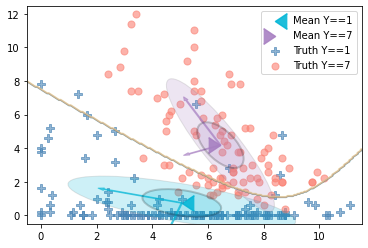

In [22]:
fig, ax = plt.subplots()
plotDecisionRegionsDA(x=X_train,y=Y_train,model=predict_qda)
plt.scatter(x=X_train[Y_train == 1,0],y=X_train[Y_train == 1,1], marker="P", color='steelblue',alpha=0.6,s=50,label="Truth Y==1")
plt.scatter(x=X_train[Y_train == 7,0],y=X_train[Y_train == 7,1], marker="o", color='salmon',alpha=0.6,s=50,label="Truth Y==7")
plt.legend()
plt.show()


In [23]:
# 5.4 Performance evaluation (3 points)

from sklearn.model_selection import KFold
import pandas as pd

def evaluateDA(X,Y,k,model):
    cv = KFold(n_splits=k, shuffle=True)
    errTs = []
    errTx = []
    for train_ind, test_ind in cv.split(Y):
        X_train, Y_train = X[train_ind,:], Y_sub[train_ind,]
        X_test, Y_test = X[test_ind,:], Y_sub[test_ind,]
        #print(np.take(Y_sub,train_index), np.take(Y_sub,test_index))
        if model == predict_qda:
            mu, covmat, p = fit_qda(training_features=X_train, training_labels=Y_train)
            predicted_test_labels = predict_qda(mu=mu, covmat=covmat, p=p, test_features=X_test)
            predicted_train_labels = predict_qda(mu=mu, covmat=covmat, p=p, test_features=X_train)  
        elif model == predict_lda:
            mu, covmat, p = fit_lda(training_features=X_train, training_labels=Y_train)
            predicted_test_labels = predict_lda(mu=mu, covmat=covmat, p=p, test_features=X_test)
            predicted_train_labels = predict_lda(mu=mu, covmat=covmat, p=p, test_features=X_train)  
        errA = calDAerror(true_labels=Y_train,predicted_labels=predicted_train_labels)
        errB = calDAerror(true_labels=Y_test,predicted_labels=predicted_test_labels)
        errTs = np.append(errTs,errA)
        errTx = np.append(errTx,errB)
        #print(errA,errB)
    df = pd.DataFrame({'Train error':errTs,
                        'Test error':errTx})
    print(df)
    df = pd.DataFrame({'Train error Mean':[np.mean(errTs)],
                        'Train error Std':[np.std(errTs)],
                        'Test error Mean':[np.mean(errTx)],
                        'Test error Std':[np.std(errTx)] })
    print(df)


In [24]:
evaluateDA(X=reduced_x,Y=Y_sub,k=10,model=predict_qda)


   Train error  Test error
0     0.138889    0.081081
1     0.120000    0.166667
2     0.132308    0.055556
3     0.141538    0.083333
4     0.132308    0.111111
5     0.123077    0.250000
6     0.126154    0.222222
7     0.144615    0.083333
8     0.132308    0.083333
9     0.110769    0.250000
   Train error Mean  Train error Std  Test error Mean  Test error Std
0          0.130197         0.009869         0.138664        0.072611


In [25]:
# 6 LDA (8 points)
# 6.1 Implement LDA Training (6 points)

def fit_lda(training_features, training_labels):
    training_labels = (training_labels == list(set(training_labels))[0]).__invert__().astype(int)
    TL = set(training_labels)   # [1,7]
    p = [len(training_features[training_labels==tl,:])/len(training_features) for tl in TL]
    mu = np.array([np.mean(training_features[training_labels==tl, : ], axis=0) for tl in TL])  # ==1,==7  ,  (2,2)
    covmat = np.cov(training_features.T)
    return mu, covmat, p


In [26]:
mu, covmat, p = fit_lda(training_features=X_train, training_labels=Y_train)


In [27]:
# 6.2 Implement LDA Prediction (3 points)

def predict_lda(mu, covmat, p, test_features):
    TF = test_features
    #ps = np.array([]).reshape(len(TF),2)
    ps = []
    for i in range(len(TF)):  # number of sample
        for k in range(len(p)):   # number of class
            d = TF[i, :] - mu[k,:]   # diff of means
            M = (-1/2) * np.dot( np.dot(d.T, np.linalg.inv(covmat[:,:])), d)    # Mahalanobis Distance
            g = 1 / np.sqrt((2 * np.pi ** mu.shape[1]) * np.linalg.det(covmat[:,:]))    # terms before exp
            pp = g * np.e ** M * p[k] # Concatenate all the terms
            ps = np.append(ps, pp)
    ps = np.array(ps).reshape(len(TF),TF.shape[1])
    test_labels = np.argmax(ps, axis=1)
    return test_labels


In [28]:
predicted_train_labels = predict_lda(mu=mu, covmat=covmat, p=p, test_features=X_train)
predicted_test_labels = predict_lda(mu=mu, covmat=covmat, p=p, test_features=X_test)


In [29]:
calDAerror(true_labels=Y_train,predicted_labels=predicted_train_labels)


[0.18518518518518517]

In [30]:
calDAerror(true_labels=Y_test,predicted_labels=predicted_test_labels)


[0.15862068965517243]

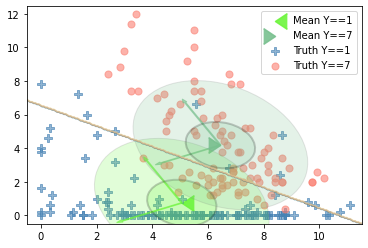

In [31]:
# 6.3 Visualization (5 points)

fig, ax = plt.subplots()
plotDecisionRegionsDA(x=X_train,y=Y_train,model=predict_lda)
plt.scatter(x=X_train[Y_train == 1,0],y=X_train[Y_train == 1,1], marker="P", color='steelblue',alpha=0.6,s=50,label="Truth Y==1")
plt.scatter(x=X_train[Y_train == 7,0],y=X_train[Y_train == 7,1], marker="o", color='salmon',alpha=0.6,s=50,label="Truth Y==7")
plt.legend()
plt.show()


In [32]:
# 6.4 Performance evaluation (3 points)

from sklearn.model_selection import KFold
evaluateDA(X=reduced_x,Y=Y_sub,k=10,model=predict_lda)


   Train error  Test error
0     0.157407    0.216216
1     0.150769    0.305556
2     0.160000    0.222222
3     0.169231    0.111111
4     0.172308    0.111111
5     0.169231    0.138889
6     0.160000    0.222222
7     0.166154    0.138889
8     0.166154    0.166667
9     0.172308    0.138889
   Train error Mean  Train error Std  Test error Mean  Test error Std
0          0.164356         0.006718         0.177177        0.059415
